In [1]:
from CNNBiLSTM_LoadData import load_data
from tensorflow.keras.utils import to_categorical
import numpy as np

data_batches = load_data('VideoFrameAudio-Simple',process_audio = False)

for item in data_batches:
    normalized_images = [image_data / 255.0 for image_data in item['images']]
    item['images'] = np.array(normalized_images)

from tensorflow.keras.utils import to_categorical
image_data = [item['images'] for item in data_batches]
image_data = np.array(image_data)


categories = [item['category'] for item in data_batches]
categories = np.array(categories)
num_classes = len(np.unique(categories))
labels = to_categorical(categories, num_classes)

2024-01-05 00:20:15.728237: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 00:20:15.798545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 00:20:16.772438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


categories ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
start process Anger all imagefiles 32961 all audiofiles 32961
start process Disgust all imagefiles 35179 all audiofiles 35179
start process Fear all imagefiles 32070 all audiofiles 32070
start process Happy all imagefiles 30031 all audiofiles 30031
start process Neutral all imagefiles 26070 all audiofiles 26070
start process Sad all imagefiles 32565 all audiofiles 32565
process all files


In [2]:
# 调整形状，适应新网络
print(image_data.shape)
print(labels.shape)
X = image_data.reshape(-1, 50,50,3)
y = np.repeat(labels, repeats=10, axis=0)
print(X.shape)
print(y.shape)

(18886, 10, 50, 50, 3)
(18886, 6)
(188860, 50, 50, 3)
(188860, 6)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def conv_bn_relu(x, filters, kernel_size, strides=1):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(tensor, filters):
    x = conv_bn_relu(tensor, filters, kernel_size=3)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Add()([x, tensor])
    x = Activation('relu')(x)
    return x

def conv_block(tensor, filters, strides):
    # Shortcut connection
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False)(tensor)
    shortcut = BatchNormalization()(shortcut)

    # Main path
    x = conv_bn_relu(tensor, filters, kernel_size=3, strides=strides)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = conv_bn_relu(inputs, 64, kernel_size=7, strides=2)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # First residual block
    x = conv_block(x, 64, strides=1)
    x = identity_block(x, 64)

    # Second residual block
    x = conv_block(x, 128, strides=2)
    x = identity_block(x, 128)

    # Third residual block
    x = conv_block(x, 256, strides=2)
    x = identity_block(x, 256)
    
    # Fourth residual block
    x = conv_block(x, 512, strides=2)
    x = identity_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

height, width, channels = 50, 50, 3
num_classes = 6
input_shape = (height, width, channels)  # Adjust input shape to include time steps
model = build_resnet18(input_shape, num_classes)

LR = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-01-05 00:22:03.595298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:31:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 25, 25, 64)           9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 25, 25, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 25, 25, 64)           0         ['batch_normalization[0][0

In [4]:
# 配置模型检查点
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
checkpoint = ModelCheckpoint(
    'temp/CNNBiLSTM_image_resnet182d_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
X_shuffle, y_shuffle = shuffle(X, y, random_state=42) # random_state 参数确保了结果可以复现
history = model.fit(
    X_shuffle, y_shuffle, 
    epochs=50, 
    batch_size=100, 
    # validation_data=(x_val, y_val),
    validation_split=0.3,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/50


2024-01-05 00:22:29.711116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-05 00:22:30.282508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-05 00:22:30.310423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd25c043cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-05 00:22:30.310490: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-05 00:22:30.319709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-05 00:22:30.506709: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

1323/1323 [==============================] - ETA: 0s - loss: 0.6601 - accuracy: 0.7613
Epoch 1: saving model to temp/CNNBiLSTM_image_resnet182d_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1323/1323 [==============================] - 56s 32ms/step - loss: 0.6601 - accuracy: 0.7613 - val_loss: 0.9476 - val_accuracy: 0.6849
Epoch 2/50
1323/1323 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8933
Epoch 2: saving model to temp/CNNBiLSTM_image_resnet182d_02.h5
1323/1323 [==============================] - 36s 27ms/step - loss: 0.3073 - accuracy: 0.8933 - val_loss: 0.8331 - val_accuracy: 0.7432
Epoch 3/50
1321/1323 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9230
Epoch 3: saving model to temp/CNNBiLSTM_image_resnet182d_03.h5
1323/1323 [==============================] - 36s 27ms/step - loss: 0.2214 - accuracy: 0.9230 - val_loss: 0.3854 - val_accuracy: 0.8657
Epoch 4/50
1323/1323 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9463
Epoch 4: saving model to temp/CNNBiLSTM_image_resnet182d_04.h5
1323/1323 [==============================] - 35s 27ms/step - loss: 0.1546 - accuracy: 0.9463 - val_loss: 0.4693 

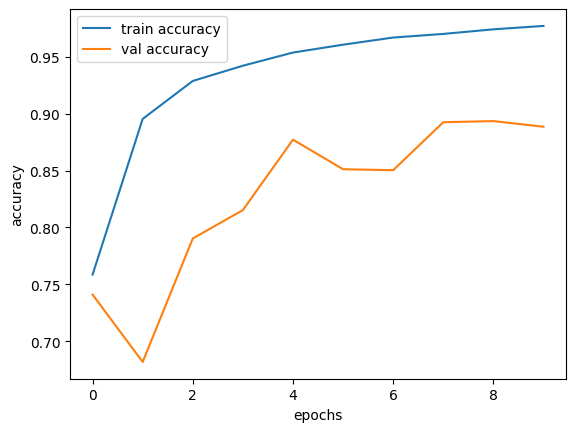

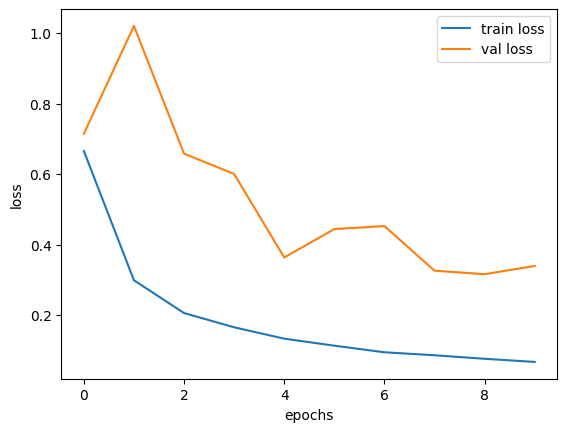

In [11]:
from CNNBiLSTM_LoadData import draw_history
draw_history(history,50)

In [5]:
import tensorflow as tf
import numpy as np
model=tf.keras.models.load_model("temp/CNNBiLSTM_image_resnet182d_46.h5")
x_test = np.load('VideoFramePickle/x_test.npy')
y_test = np.load('VideoFramePickle/y_test.npy')
x_test = x_test.reshape(-1,50,50,3)
y_test = np.repeat(y_test, repeats=10, axis=0)
loss,acc = model.evaluate(x_test,y_test)
print(f"loss {loss},acc {acc}")

1780/1780 [==============================] - 15s 8ms/step - loss: 1.7793 - accuracy: 0.7347
loss 1.7793134450912476,acc 0.7347092628479004
